# Home Credit 2024 Kaggle
 By Andrew Scott

Code Credit: Starter notebook provider by project sponsor providing code to join all of the data files and prepare the x and y matrixes (https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook). 

Steps:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Analyze the data
* Encode features and deal with NaNs
* Train a Logistic Regression model
* Train a Decision Tree Model
* Import Keras and train two Multilayer Perceptron Classifiers
* Create a submission table

## Load the data

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

dataPath = "/Users/andrewscott/Documents/USF/Spring24/DSP/kaggle/home-credit-credit-risk-model-stability/"


In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [9]:
df = data.to_pandas()
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df = df.dropna()

df

,case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,...,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
51884,51884,2020-06-06,202006,74,0,0.0,4383.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,0.0,0.0,120000.0,False,OWNED,0.000000,False
51948,51948,2020-06-08,202006,74,0,0.0,8252.8,0.0,0.0000,0.0,...,977b2a70,0.0,0.0,0.0,0.0,48979.8,False,OWNED,10.000000,True
52048,52048,2020-06-09,202006,75,0,3408.0,10645.4,0.0,1136.0000,32338.0,...,1a19667c,0.0,0.0,0.0,0.0,70000.0,False,OWNED,0.600000,True
52141,52141,2020-06-11,202006,75,0,0.0,4443.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,14020.8,0.0,190000.0,False,OWNED,0.000000,False
52182,52182,2020-06-11,202006,75,1,0.0,7405.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,0.0,0.0,90000.0,False,PARENTAL,0.600000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524781,2701536,2020-09-25,202009,90,0,10786.8,5103.2,0.0,3592.6000,0.0,...,46b968c3,0.0,0.0,0.0,0.0,80000.0,False,OWNED,0.000000,False
1525906,2702661,2020-10-01,202010,91,0,80665.2,4133.0,4000.0,6722.2000,21420.0,...,46b968c3,0.0,0.0,14105.0,0.0,18000.0,False,OWNED,0.000000,False
1526569,2703357,2020-10-05,202010,91,0,10840.4,4521.6,0.0,5419.8003,0.0,...,a55475b1,0.0,0.0,0.0,0.0,50000.0,False,OWNED,10.400001,True
1526587,2703377,2020-10-05,202010,91,0,111463.2,7459.2,0.0,6192.4000,0.0,...,46b968c3,0.0,0.0,0.0,0.0,60000.0,False,OWNED,0.000000,False


## Training LightGBM

Minimal example of LightGBM training is shown below.

In [10]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "num_leaves": 40,
    "learning_rate": 0.025,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "n_estimators": 2000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.722528
[100]	valid_0's auc: 0.735563
[150]	valid_0's auc: 0.742572
[200]	valid_0's auc: 0.746786
[250]	valid_0's auc: 0.749424
[300]	valid_0's auc: 0.751034
[350]	valid_0's auc: 0.753172
[400]	valid_0's auc: 0.75414
[450]	valid_0's auc: 0.755056
[500]	valid_0's auc: 0.755484
[550]	valid_0's auc: 0.75574
[600]	valid_0's auc: 0.756257
[650]	valid_0's auc: 0.756662
[700]	valid_0's auc: 0.756984
Early stopping, best iteration is:
[710]	valid_0's auc: 0.75701


Evaluation with AUC and then comparison with the stability metric is shown below.

In [11]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  


The AUC score on the train set is: 0.8093673261934202
The AUC score on the valid set is: 0.757009981174771
The AUC score on the test set is: 0.7546619281038809


In [12]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The stability score on the train set is: 0.5978419708321412
The stability score on the valid set is: 0.4832031486057384
The stability score on the test set is: 0.46853633163257336


In [13]:
results = pd.DataFrame({
        "Model": 'Light GBM',
        "AUC_Train": roc_auc_score(base_train["target"], base_train["score"]),
        "AUC_Valid": roc_auc_score(base_valid["target"], base_valid["score"]),
        "AUC_Test": roc_auc_score(base_test["target"], base_test["score"]),
        "Stability Score Train": stability_score_train,
        "Stability Score Valid": stability_score_valid,
        "Stability Score Test": stability_score_test,},
        index=[0]
    )
results

,Model,AUC_Train,AUC_Valid,AUC_Test,Stability Score Train,Stability Score Valid,Stability Score Test
0,Light GBM,0.809367,0.75701,0.754662,0.597842,0.483203,0.468536


# Data Exploration

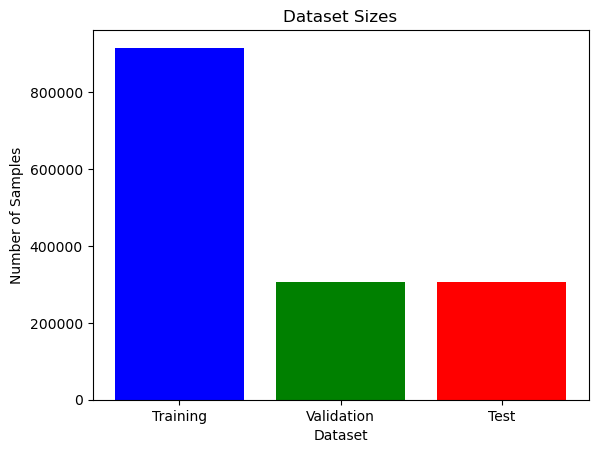

In [14]:
# Volume of data
import matplotlib.pyplot as plt

labels = ['Training', 'Validation', 'Test']
sizes = [base_train.shape[0], base_valid.shape[0], base_test.shape[0]]

plt.bar(labels, sizes, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()

In [15]:
base_train.groupby('target').count()['case_id'].tolist()

[887123, 28872]

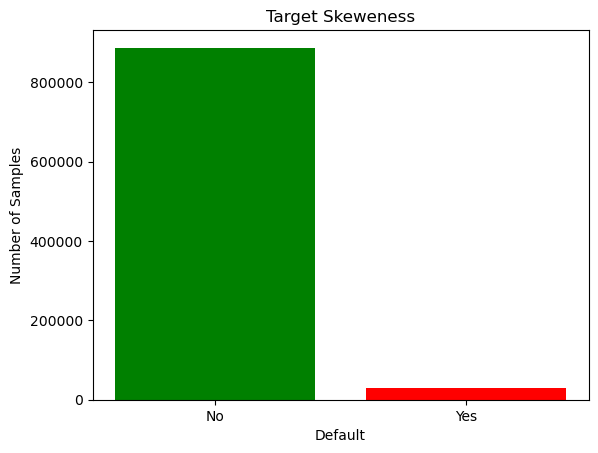

In [16]:
labels = ['No', 'Yes']
sizes = base_train.groupby('target').count()['case_id'].tolist()

plt.bar(labels, sizes, color=['green', 'red'])
plt.xlabel('Default')
plt.ylabel('Number of Samples')
plt.title('Target Skeweness')
plt.show()

Skewed dataset, 

In [17]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

# Weights for use later
weight_for_0  = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]


Number of positive samples in training data: 28872 (3.15% of total)


# Models

Set Predictions method

In [18]:
# Predictions and Evaluation

def get_pred(name,model):
    for base, X in [(base_train, X_train_1h), (base_valid, X_valid_1h), (base_test, X_test_1h)]:
        y_pred = model.predict(X)
        base["score"] = y_pred

    auc_train = roc_auc_score(base_train["target"], base_train["score"])
    auc_valid = roc_auc_score(base_valid["target"], base_valid["score"])
    auc_test = roc_auc_score(base_test["target"], base_test["score"])

    print(f'The AUC score on the train set is: {auc_train}') 
    print(f'The AUC score on the valid set is: {auc_valid}') 
    print(f'The AUC score on the test set is: {auc_test}')  
    
    stability_score_train = gini_stability(base_train)
    stability_score_valid = gini_stability(base_valid)
    stability_score_test = gini_stability(base_test)
    
    print(f'The stability score on the train set is: {stability_score_train}') 
    print(f'The stability score on the valid set is: {stability_score_valid}') 
    print(f'The stability score on the test set is: {stability_score_test}') 

    df = pd.DataFrame({
        "Model": name,
        "AUC_Train": auc_train,
        "AUC_Valid": auc_valid,
        "AUC_Test": auc_test,
        "Stability Score Train": stability_score_train,
        "Stability Score Valid": stability_score_valid,
        "Stability Score Test": stability_score_test
    }, index=[0])
    return(df)

    

In [69]:
display(X_train.head())
print(X_train.dtypes)


,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0.0,1917.6,0.0,0.0,0.0,0.0,0.0,30000.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,0.0,4937.0,0.0,0.0,0.0,0.0,0.0,78000.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,0.0,3600.0,0.0,0.0,0.0,0.0,0.0,60000.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,0.0,3110.8,0.0,0.0,0.0,0.0,0.0,20000.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,0.0,1218.0,0.0,0.0,0.0,0.0,0.0,20300.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


amtinstpaidbefduel24m_4187115A      float64
annuity_780A                        float64
annuitynextmonth_57A                float64
avginstallast24m_3658937A           float64
avglnamtstart24m_4525187A           float64
avgoutstandbalancel6m_4187114A      float64
avgpmtlast12m_4525200A              float64
credamount_770A                     float64
currdebt_22A                        float64
currdebtcredtyperange_828A          float64
disbursedcredamount_1113A           float64
downpmt_116A                        float64
inittransactionamount_650A          float64
lastapprcommoditycat_1041M         category
lastapprcommoditytypec_5251766M    category
lastapprcredamount_781A             float64
lastcancelreason_561M              category
lastotherinc_902A                   float64
lastotherlnsexpense_631A            float64
lastrejectcommoditycat_161M        category
lastrejectcommodtypec_5251769M     category
lastrejectcredamount_222A           float64
lastrejectreason_759M           

## Pre-process features for SKLearn

In [20]:
# Fill NAs

numeric_columns = X_train.select_dtypes(include=['number']).columns
X_train[numeric_columns] = X_train[numeric_columns].fillna(0)
X_valid[numeric_columns] = X_valid[numeric_columns].fillna(0)
X_test[numeric_columns] = X_test[numeric_columns].fillna(0)

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = X_train.select_dtypes(include=['number']).columns # List of numerical feature column names
categorical_features = X_train.select_dtypes(include=['category']).columns # List of categorical feature column names

# Define preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the entire dataset
X_train_1h = preprocessor.fit_transform(X_train)
X_valid_1h = preprocessor.transform(X_valid)
X_test_1h = preprocessor.transform(X_test)

X_train_1h.shape, X_valid_1h.shape, X_test_1h.shape

((915995, 826), (305332, 826), (305332, 826))

## Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(solver='liblinear',random_state=42)

logr.fit(X_train_1h,y_train)



LogisticRegression(random_state=42, solver='liblinear')

In [59]:
logistic_regression_results = get_pred('Logistic Regression', logr)

The AUC score on the train set is: 0.5003761742186033
The AUC score on the valid set is: 0.5001712639178778
The AUC score on the test set is: 0.5004242877738884
The stability score on the train set is: -0.00023986460319415663
The stability score on the valid set is: -0.0004521883198931949
The stability score on the test set is: -0.0009711942615667174


In [24]:
#y_pred = logr.predict(X_test_1h)

# Predictions and Evaluation

for base, X in [(base_train, X_train_1h), (base_valid, X_valid_1h), (base_test, X_test_1h)]:
    y_pred = logr.predict(X)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The AUC score on the train set is: 0.5003247843885953
The AUC score on the valid set is: 0.5002242188003181
The AUC score on the test set is: 0.5005242112040815
The stability score on the train set is: -0.0001361315617912292
The stability score on the valid set is: -0.0005807936602557
The stability score on the test set is: -0.0009350378137794547


Confusion Matrix:


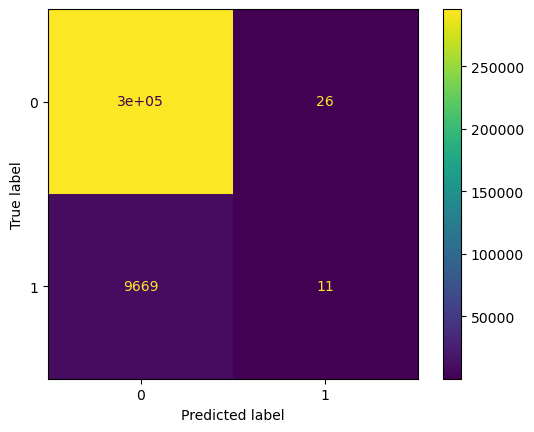

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(base_test["target"], base_test["score"])
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_).plot()



## Decision Tree

In [60]:
%%time
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(max_depth=8, 
                                      min_samples_split=4, 
                                      min_samples_leaf=2)
DecisionTree.fit(X_train_1h,y_train)

CPU times: user 14 s, sys: 535 ms, total: 14.5 s
Wall time: 14.7 s


DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=4)

In [61]:
# Predictions and Evaluation

decision_tree_results = get_pred('Decision Tree', DecisionTree)

The AUC score on the train set is: 0.5034873357785971
The AUC score on the valid set is: 0.5013148742588831
The AUC score on the test set is: 0.5009146754286617
The stability score on the train set is: 0.004543354266393362
The stability score on the valid set is: -0.0011370761192143384
The stability score on the test set is: -0.0009780598785072106


## Deep Neural Network With Keras

In [78]:
import tensorflow as tf

X_train_tensor = tf.sparse.SparseTensor(indices=np.column_stack(X_train_1h.nonzero()),
                                       values=X_train_1h.data,
                                       dense_shape=X_train_1h.shape)
X_train_tensor = tf.sparse.to_dense(X_train_tensor)
X_valid_tensor = tf.sparse.SparseTensor(indices=np.column_stack(X_valid_1h.nonzero()),
                                       values=X_valid_1h.data,
                                       dense_shape=X_valid_1h.shape)
X_test_tensor = tf.sparse.SparseTensor(indices=np.column_stack(X_test_1h.nonzero()),
                                       values=X_test_1h.data,
                                       dense_shape=X_test_1h.shape)

### First NN Model

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_features = X_train_1h.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        52,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,153 (223.25 KB)

 Trainable params: 57,153 (223.25 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','auc'])

history = model.fit(X_train_tensor, y_train, epochs=10, batch_size=2048, validation_data=(X_valid_tensor, y_valid))

loss, accuracy, auc = model.evaluate(X_test_tensor, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9575 - auc: 0.6178 - loss: 0.1830 - val_accuracy: 0.9691 - val_auc: 0.7267 - val_loss: 0.1272
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9682 - auc: 0.7306 - loss: 0.1295 - val_accuracy: 0.9691 - val_auc: 0.7344 - val_loss: 0.1265
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9685 - auc: 0.7382 - loss: 0.1277 - val_accuracy: 0.9691 - val_auc: 0.7357 - val_loss: 0.1265
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9684 - auc: 0.7434 - loss: 0.1273 - val_accuracy: 0.9691 - val_auc: 0.7374 - val_loss: 0.1267
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9683 - auc: 0.7467 - loss: 0.1270 - val_accuracy: 0.9691 - val_auc: 0.7401 - val_loss: 0.1258
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9686 - auc: 0.7522 - loss: 0.1258 - val_accuracy: 0.9690 - val_auc: 0.7406 - val_loss: 0.1257
Epoch 7/10
448/448 ━━━━━━━━━━━━━━

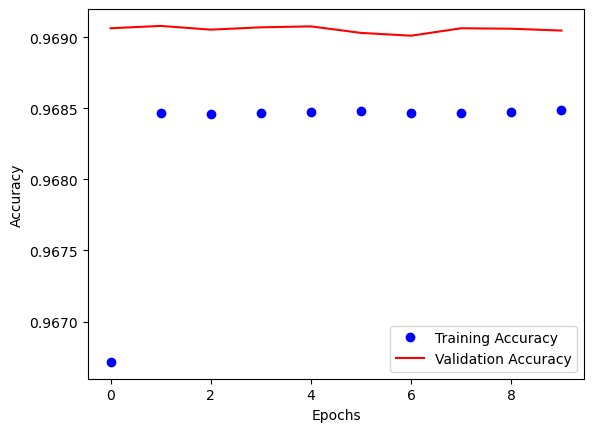

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(10) # 50 is the number of epochs
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [89]:
print('The Results of Model 1 are')
nn1_results = get_pred('Neural Network 1', model)

The Results of Model 1 are
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
The AUC score on the train set is: 0.7793840205058908
The AUC score on the valid set is: 0.7373680742632442
The AUC score on the test set is: 0.7352056806888666
The stability score on the train set is: 0.529867499471682
The stability score on the valid set is: 0.43439374587379626
The stability score on the test set is: 0.4274085890216677


In [103]:
y_pred = model.predict(X_test_1h)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step


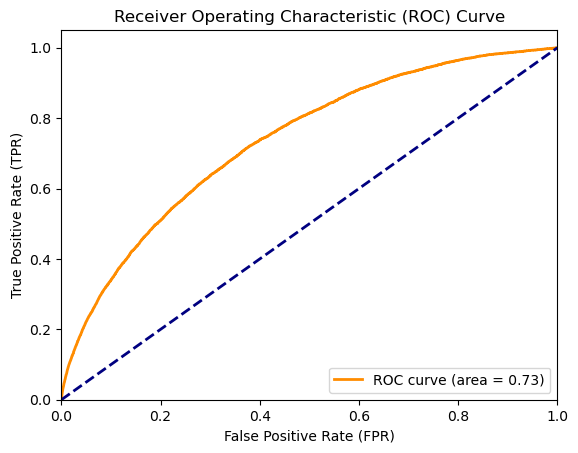

In [104]:
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, _ = roc_curve(np.array(y_test), y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [105]:
model.save("home_credit_nn1.keras")

### Second NN Model
#### More layers and Attention to the inputs

In [106]:
X_train_1h
X_train_1h_dense = X_train_1h.toarray()
X_valid_1h_dense = X_valid_1h.toarray()

print(X_train_1h_dense

SyntaxError: incomplete input (1374100518.py, line 5)

In [107]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, Concatenate, Reshape


# Define input layer
inputs = Input(shape=(num_features,))

# Encoder
encoder = Dense(256, activation="relu")(inputs)
encoder = Dense(256, activation="relu")(encoder)

# Reshape encoder output
encoder_reshaped = Reshape((1, 256))(encoder)

# Attention 
attention = Attention()([encoder_reshaped, encoder_reshaped])

# Flatten attention output
attention_flatten = tf.keras.layers.Flatten()(attention)

# Concatenate encoder output and attention output
combined = Concatenate(axis=-1)([encoder, attention_flatten])

# Additional layers
dropout = Dropout(0.3)(combined)
dense1 = Dense(256, activation="relu")(dropout)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

# Create model
model2 = Model(inputs=inputs, outputs=output)
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 826)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    211,712 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 256)    │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 409,089 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
%%time
from tensorflow.keras.optimizers import Adam

epochs = 30

model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy','precision','recall','auc'])

class_weight = {0: weight_for_0, 1: weight_for_1}

history2 = model2.fit(X_train_tensor, y_train, epochs=epochs, batch_size=2048, validation_data=(X_valid_tensor, y_valid),class_weight=class_weight)

loss, accuracy, precision, recall, auc = model2.evaluate(X_test_tensor, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30


You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?


448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6470 - auc: 0.7257 - loss: 1.3316e-06 - precision: 0.0589 - recall: 0.6830 - val_accuracy: 0.6260 - val_auc: 0.7307 - val_loss: 0.6219 - val_precision: 0.0568 - val_recall: 0.7115
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6437 - auc: 0.7304 - loss: 1.3247e-06 - precision: 0.0592 - recall: 0.6929 - val_accuracy: 0.6333 - val_auc: 0.7328 - val_loss: 0.6139 - val_precision: 0.0576 - val_recall: 0.7066
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6472 - auc: 0.7286 - loss: 1.3253e-06 - precision: 0.0588 - recall: 0.6828 - val_accuracy: 0.6201 - val_auc: 0.7344 - val_loss: 0.6266 - val_precision: 0.0567 - val_recall: 0.7216
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6394 - auc: 0.7328 - loss: 1.3255e-06 - precision: 0.0597 - recall: 0.7002 - val_accuracy: 0.6125 - val_auc: 0.7359 - val_loss: 0.6316 - val_precision: 0.0563 - val_recall: 0.7316
Epoch 5/30
448/448 

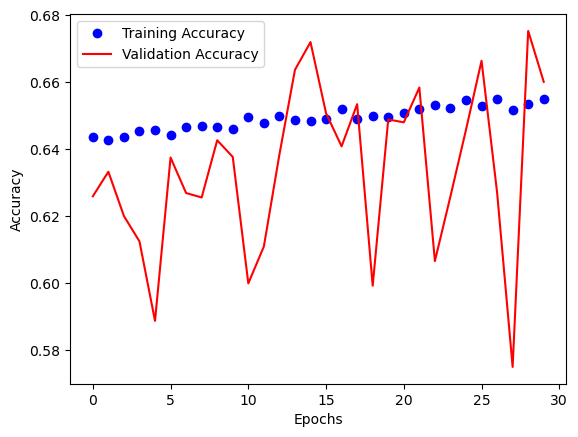

In [112]:

train_acc = history2.history['accuracy']
valid_acc = history2.history['val_accuracy']
plt.plot(range(epochs), train_acc, 'bo', label='Training Accuracy')
plt.plot(range(epochs), valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [113]:
print('The Results of Model 2 are')
nn2_results = get_pred('Neural Network 2', model2)

The Results of Model 2 are
    1/28625 ━━━━━━━━━━━━━━━━━━━━ 1:34:25 198ms/step

You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?


28625/28625 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step
The AUC score on the train set is: 0.7639824051335036
The AUC score on the valid set is: 0.748198871993891
The AUC score on the test set is: 0.7441541045841475
The stability score on the train set is: 0.49661169550033446
The stability score on the valid set is: 0.46426947438150407
The stability score on the test set is: 0.4513885721392564


9542/9542 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step


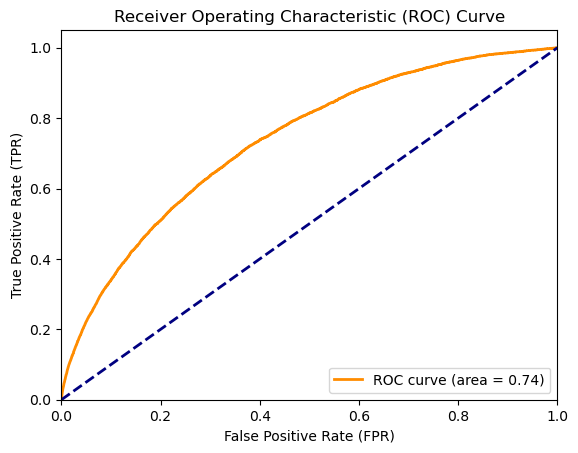

In [114]:
y_pred = model.predict(X_test_1h)
# Calculate ROC curve
fpr, tpr, _ = roc_curve(np.array(y_test), y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [115]:
model2.save("home_credit_nn2.keras")

### Evaluation Comparison

In [116]:
dfs = [results, logistic_regression_results, decision_tree_results, nn1_results, nn2_results]

# Concatenate the DataFrames
results = pd.concat(dfs, ignore_index=True)

In [117]:
results

,Model,AUC_Train,AUC_Valid,AUC_Test,Stability Score Train,Stability Score Valid,Stability Score Test
0,Light GBM,0.809367,0.757010,0.754662,0.597842,0.483203,0.468536
1,Logistic Regression,0.500376,0.500171,0.500424,-0.000240,-0.000452,-0.000971
2,Decision Tree,0.503487,0.501315,0.500915,0.004543,-0.001137,-0.000978
3,Neural Network 1,0.779384,0.737368,0.735206,0.529867,0.434394,0.427409
4,Neural Network 2,0.763982,0.748199,0.744154,0.496612,0.464269,0.451389


## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

#### Load Winning Model

In [62]:
from tensorflow.keras.models import load_model
model = load_model("home_credit_nn2.keras")

In [80]:
import lime

def predict_fn(x):
    return model.predict(X_train_tensor)

feature_names = list(X_train.columns.values)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_tensor, mode='classification', feature_names=feature_names, class_names=['class_0', 'class_1'])

instance_idx = 0
instance = X_train_tensor[instance_idx].reshape(1, -1)
exp = explainer.explain_instance(instance[0], predict_fn, num_features=len(feature_names))

# Print the explanation
exp.show_in_notebook()

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ True,  True,  True, ..., False, False, False])

In [46]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

# Fill NAs
numeric_columns = X_submission.select_dtypes(include=['number']).columns
X_submission[numeric_columns] = X_submission[numeric_columns].fillna(0)

X_submission_1h = preprocessor.transform(X_submission)

y_submission_pred = model.predict(X_submission_1h).flatten()

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (10, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


In [47]:
y_submission_pred
#X_submission


array([0.29938084, 0.6076437 , 0.09697518, 0.3112704 , 0.5692632 ,
       0.11714818, 0.54286695, 0.06585234, 0.5275591 , 0.14675139],
      dtype=float32)

In [48]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")